In [1]:
# Uncomment this line if the you do not have the plotly library
# pip install plotly

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path
import scipy.ndimage as ndi
from skimage import io, segmentation, filters, measure

import plotly
import plotly.express as px
import plotly.graph_objects as go

### Open and read images

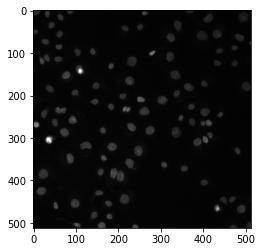

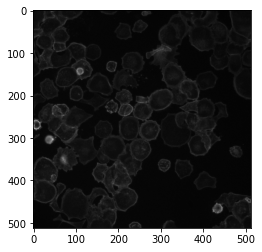

In [3]:
def vector_of_images(channel_choice='DNA'):
    '''
    Open images -- Separation between DNA and actin
    @channel_choice: 'DNA', 'actin', 'pH3'
    '''
    directory = './Images/'
    return [io.imread(jpg) for jpg in glob(path.join(directory, '*-{0}.tif'.format(channel_choice)))]

nucleis = vector_of_images(channel_choice='DNA')
actins = vector_of_images(channel_choice='actin')

#Visualisation of one of this image
plt.imshow(nucleis[1],cmap='gray')
plt.show()
plt.imshow(actins[1],cmap='gray')
plt.show()

### Selecting markers from DNA images

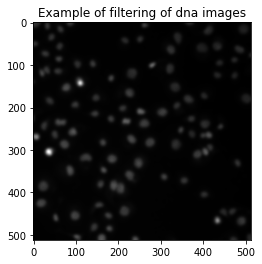

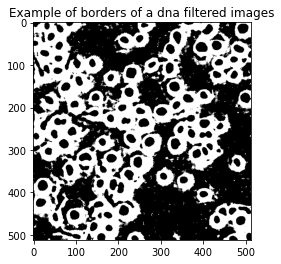

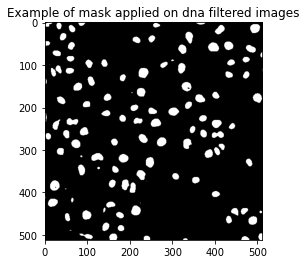

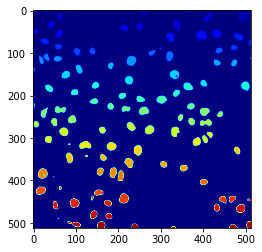

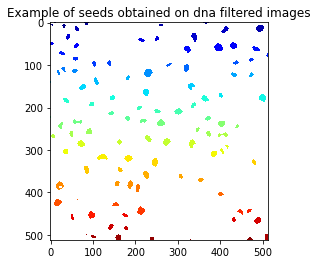

In [4]:
nuclei_filters = [ndi.gaussian_filter(nuc, sigma=3) for nuc in nucleis] #filtering
plt.imshow(nuclei_filters[1], cmap='gray')
plt.title('Example of filtering of dna images')
plt.show()

nuclei_background = [ndi.uniform_filter(nuc, size=10) for nuc in nuclei_filters] #background
nuclei_border = [nuc_f - nuc_b for (nuc_f, nuc_b) in zip(nuclei_filters, nuclei_background)] #foreground
plt.imshow(nuclei_border[1], cmap='gray')
plt.title('Example of borders of a dna filtered images')
plt.show()

nuc_mask = [] # mask to filter the nuclei
for (n_bor, nuc_f, nuc_b) in zip(nuclei_border, nuclei_filters, nuclei_background):
    n_bor[nuc_f<nuc_b] = 0
    nuc_mask.append(n_bor > 10)
plt.imshow(nuc_mask[1], cmap='gray')
plt.title('Example of mask applied on dna filtered images')
plt.show()

seeds = [ndi.label(n_m)[0] for n_m in nuc_mask] # define marker, one marker = one label
plt.imshow(seeds[1], cmap='jet')
plt.show()
plt.imshow(np.ma.array(seeds[1], mask=(seeds[1]==0)), cmap='jet')
plt.title('Example of seeds obtained on dna filtered images')
plt.show()

### Filtering the actin datasets

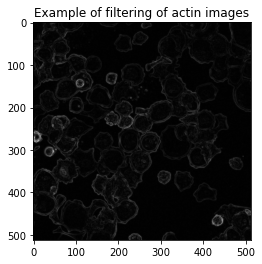

In [5]:
act_filter=[]
for (act, seed) in zip(actins, seeds):
    seed[act==0] = seed.max() + 1
    act_filter.append(filters.sobel(act))

plt.imshow(act_filter[1], cmap='gray')
plt.title('Example of filtering of actin images')
plt.show()

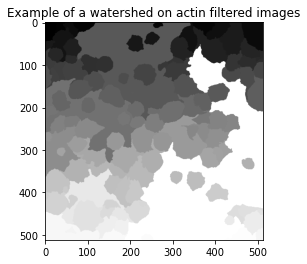

In [6]:
act_watershed = [segmentation.watershed(act_f, seed) for (act_f, seed) in zip(act_filter, seeds)]
for act_ws, seed in zip(act_watershed, seeds): 
    act_ws[act_ws==seed.max()+1] = 0
plt.imshow(act_watershed[1], cmap='gray')
plt.title('Example of a watershed on actin filtered images')
plt.show()

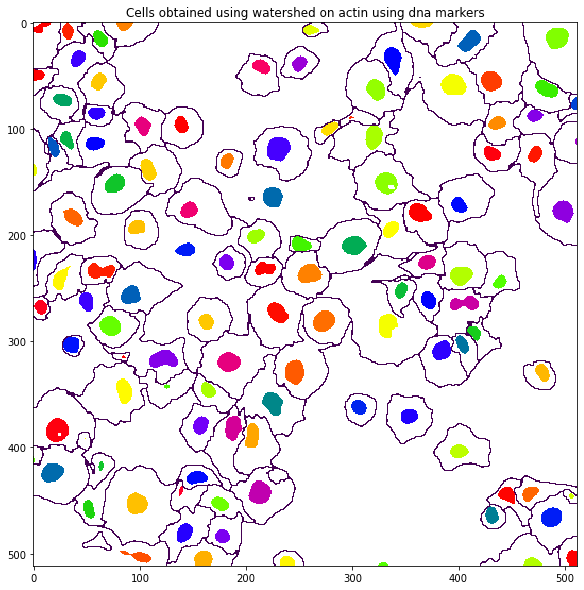

In [7]:
fig = plt.figure(figsize=(10,10))
boundaries = [filters.sobel(act_w) > 0 for act_w in act_watershed]
plt.imshow(np.ma.array(seeds[1], mask=seeds[1]==0), cmap='prism')
plt.imshow(np.ma.array(boundaries[1], mask=boundaries[1]==0))
plt.title('Cells obtained using watershed on actin using dna markers')
plt.show()

### Another visualisation, the first step towards the feature table

In [8]:
region_prop_act = measure.regionprops(seeds[1], actins[1])
fig = px.imshow(actins[1])
for index in range(1, seeds[1].max()):
    contour = measure.find_contours(seeds[1] == region_prop_act[index].label, 0.1)[0]
    y, x = contour.T
    fig.add_trace(go.Scatter(x=x, y=y, name=region_prop_act[index].label,showlegend=False))
plotly.io.show(fig)